# **1. Instalación y carga de paquetes necesarios**

En esta celda cargamos los paquetes fundamentales para manipular imágenes, entrenar el modelo GMM y visualizar los resultados.

# Importación de librerías

Se importan las librerías necesarias para:
- Lectura y procesamiento de imágenes.
- Reducción de dimensionalidad con PCA.
- Modelado con Gaussian Mixture.
- Visualización y barra de progreso.


In [40]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# **2. Carga y preprocesamiento de imágenes**

Convertiremos las imágenes a blanco y negro, las redimensionamos a 32x32 píxeles y las aplanamos.
Utilizamos `tqdm` para mostrar una barra de progreso durante la carga.


In [41]:
folder_path = './datasets/train_images'
image_vectors = []

for filename in tqdm(os.listdir(folder_path), desc="Cargando imágenes"):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('L').resize((32, 32))  # grayscale
        image_vectors.append(np.array(img).flatten())

X = np.array(image_vectors)
print(f"Dimensión del dataset: {X.shape}")  # (n_samples, 1024)


Cargando imágenes: 100%|██████████| 5000/5000 [00:03<00:00, 1552.33it/s]

Dimensión del dataset: (5000, 1024)


# **3. Reducción de dimensionalidad con PCA**

Reducimos las imágenes a 50 dimensiones para optimizar el modelo GMM.
También probaremos una versión con solo 2 dimensiones para visualización 2D.


In [42]:
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X)

pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X)


# **4. Aplicación del modelo Gaussian Mixture**

Agruparemos las imágenes en 10 grupos (clusters) sin usar etiquetas, aplicando GMM sobre los datos PCA.


In [43]:
gmm = GaussianMixture(n_components=10, covariance_type='tied', n_init=10, random_state=42)
gmm.fit(X_pca_50)
labels = gmm.predict(X_pca_50)

# **5 Visualización de ejemplos por cluster**

Mostraremos una imagen representativa de cada uno de los 10 clusters detectados por GMM.


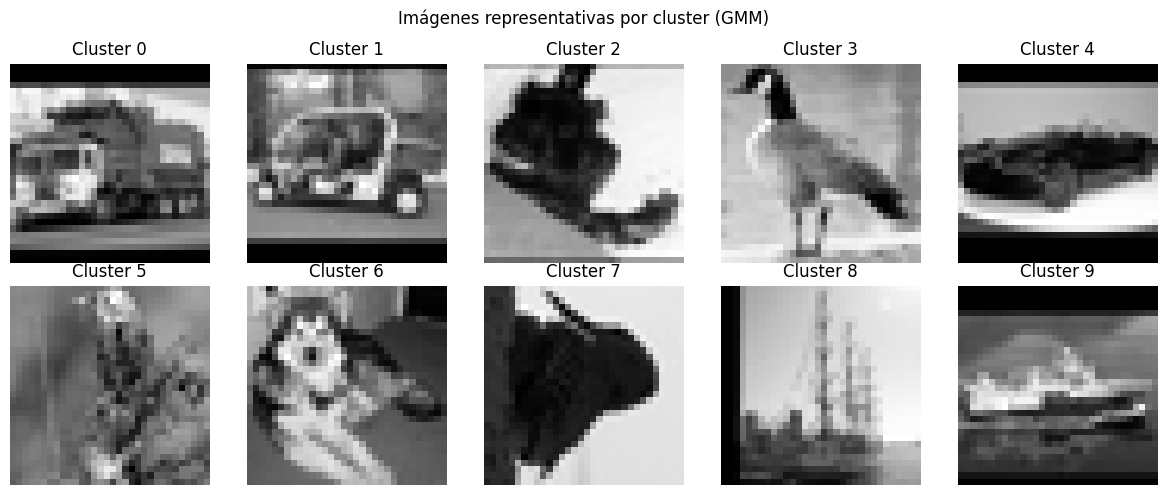

In [44]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    idx = np.where(labels == i)[0][0]
    img = X[idx].reshape(32, 32)
    axs[i//5, i%5].imshow(img, cmap='gray')
    axs[i//5, i%5].set_title(f'Cluster {i}')
    axs[i//5, i%5].axis('off')
plt.suptitle("Imágenes representativas por cluster (GMM)")
plt.tight_layout()
plt.show()


# **6. Visualización 2D de clusters**

Usando PCA a 2 componentes, visualizamos gráficamente cómo se agruparon las imágenes.


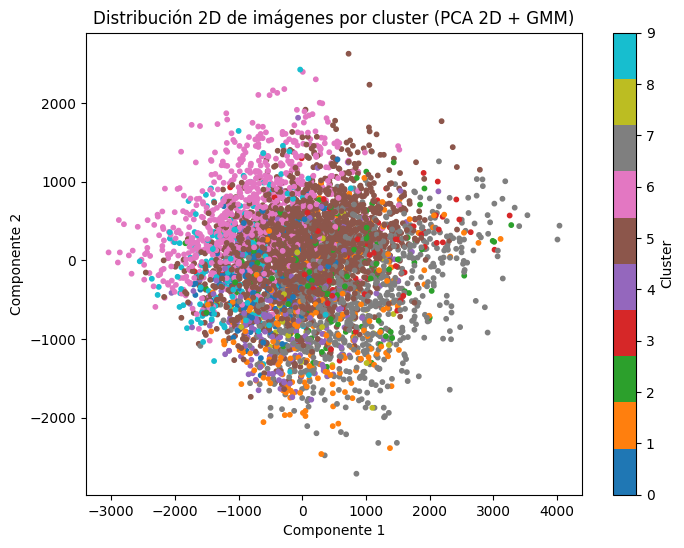

In [45]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels, cmap='tab10', s=10)
plt.title("Distribución 2D de imágenes por cluster (PCA 2D + GMM)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(scatter, label="Cluster")
plt.show()


# **7. Detección de anomalías**

Usamos las densidades del modelo GMM para identificar las imágenes menos probables (outliers).


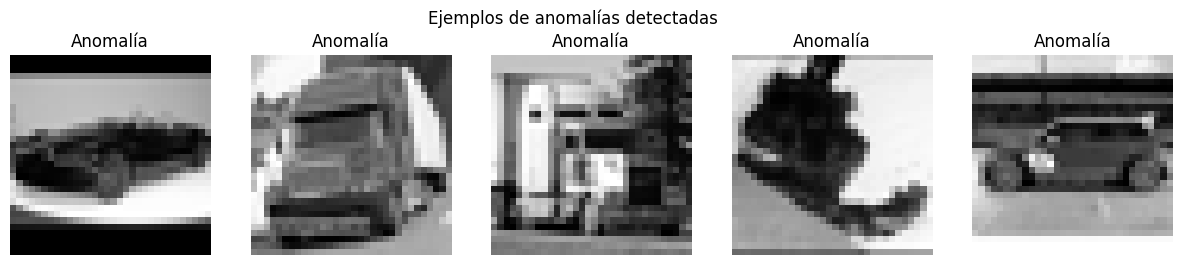

In [46]:
densities = gmm.score_samples(X_pca_50)
threshold = np.percentile(densities, 5)
anomalies = X[densities < threshold]

# Mostrar algunas anomalías
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(anomalies[i].reshape(32, 32), cmap='gray')
    axs[i].set_title("Anomalía")
    axs[i].axis('off')
plt.suptitle("Ejemplos de anomalías detectadas")
plt.show()


# **8. Funciones para visualizar Gaussian Mixture Models**

Definimos las funciones `plot_centroids()` y `plot_gaussian_mixture()` para visualizar
las regiones de densidad de las distribuciones gaussianas aprendidas.


In [47]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    for i, centroid in enumerate(centroids):
        plt.plot(*centroid, 'o', markerfacecolor=circle_color, markeredgecolor='k', markersize=10)
        plt.plot(*centroid, 'x', color=cross_color, markersize=8)
        if weights is not None:
            plt.annotate(f'{weights[i]:.2f}', (centroid[0] + 0.2, centroid[1]))

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$X_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$X_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


# **9. Visualización de regiones GMM**

Mostramos las distribuciones gaussianas en el plano 2D con sus contornos y fronteras de decisión.


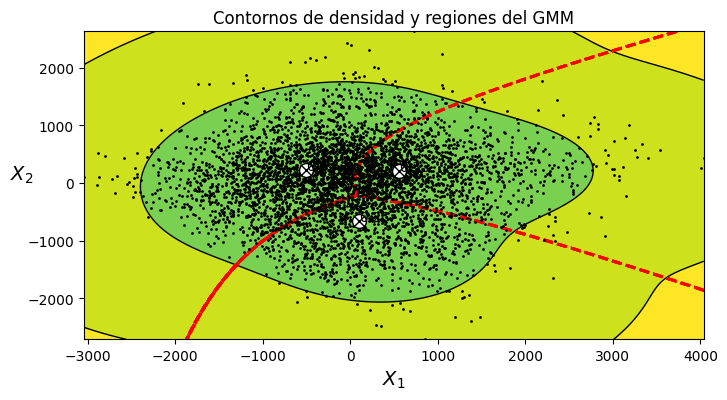

In [48]:
from sklearn.mixture import GaussianMixture

# Entrenamiento del modelo GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_pca_2)  # Asegúrate de usar datos de 2 dimensiones para graficar

# Luego usa la variable `gmm`, NO `gm`
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gmm, X_pca_2)
plt.title("Contornos de densidad y regiones del GMM")
plt.show()


# **10. Visualización de anomalías (Outliers)**

Detectamos valores con baja densidad bajo el modelo GMM (puntos fuera de las regiones densas).


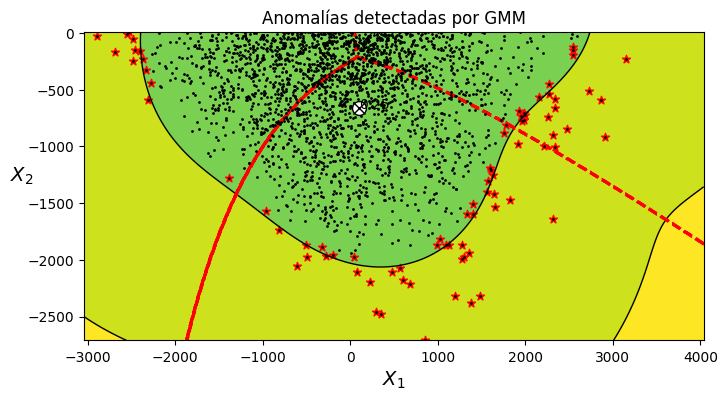

In [49]:
densities = gmm.score_samples(X_pca_2)
density_threshold = np.percentile(densities, 4)  # 4% como anomalías
anomalies = X_pca_2[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gmm, X_pca_2)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.title("Anomalías detectadas por GMM")
plt.ylim(top=5.1)
plt.show()



# **11. Visualización de pesos de cada componente gaussiana**

Mostramos qué tan dominante es cada componente en el modelo GMM.


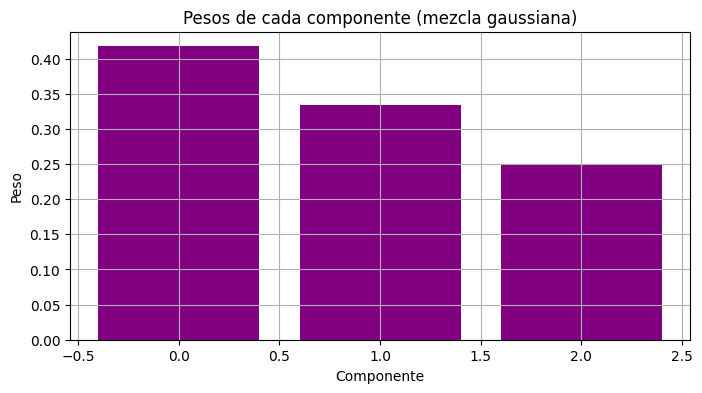

In [50]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(gmm.n_components), gmm.weights_, color='purple')
plt.title("Pesos de cada componente (mezcla gaussiana)")
plt.xlabel("Componente")
plt.ylabel("Peso")
plt.grid(True)
plt.show()
